# Pythonradex
Re-implementation of the RADEX code.
Adventages of pythonradex:
- faster
- provides a convenient method to read files from the LAMDA database, official website: https://home.strw.leidenuniv.nl/~moldata/.
- provides additional functionality that is not included in RADEX (treatment of overlapping lines)
- RADEX calculates the flux for all geometries using the equation which is only valid for slab geometry, pythonradex uses the correct formulae for spherical geometries.



In [1]:
import pythonradex

# # import necessary modules
from pythonradex import radiative_transfer, helpers, LAMDA_file, atomic_transition
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

In [2]:
print(dir(pythonradex))

['LAMDA_file', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'atomic_transition', 'escape_probability', 'escape_probability_functions', 'flux', 'helpers', 'molecule', 'radiative_transfer', 'rate_equations']


# Getting started with pythonradex

- Radiative transfer calculation is conducted using the Cloud class which is provided by the radiative_transfer module
- Possible geometries: "Gaussian",  “rectangular”, "LVG sphere", "LVG slab”
- For LVG geometries the parameter "line_profile_type" needs to be set to “rectangular”. This ensures that the optical depth is calculated correctly.


In [3]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CO from LAMBDA database
datafilepath = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\co_datafile.dat"  # file downloaded from LAMDA database


# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
line_profile_type = "Gaussian"  # line profile, can be "Gaussian",  “rectangular”,"LVG sphere", "LVG slab”
width_v = 5 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud = radiative_transfer.Cloud(
    datafilepath=datafilepath,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

## line width parameter "width_v" explained
- There are different interpretations of the input parameter width_v used by pythonradex
-  For static geometries, this refers to the local emission width, two kinds of local emission profiles:

   - "Gaussian" in which case width_v refers to the FWHM
   - "rectangular" in which case width_v refers to the FWHM
- For the LVG geometries (“LVG sphere” and “LVG slab”), width_v refers to the global velocity width of the cloud

## Set the parameters characterising the cloud physical conditions.
- use update_parameters method to do this.


In [4]:
## possible atributes of the cloud object

# update_parameters
# solve_radiative_transfer()
# fluxes_of_individual_transitions(solid_angle, transitions)

In [5]:
N = 1e18 / constants.centi**2  # CO column density in m-2
Tkin = 30  # kinetic temperature in [K]

# collider densities in cm-3:
para_h2_density = 1e8
ortho_h2_density = 3e8

# collider densities in m-3 (phytonradex takes the densities in m-3):
collider_densities_LTE = {
    "para-H2": para_h2_density / constants.centi**3,
    "ortho-H2": ortho_h2_density / constants.centi**3,
}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_LTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer equation, i.e. calculate the level population with an iterative method
cloud.solve_radiative_transfer()

In [6]:
# print the results
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      30.00      0.0893981        0.22303        4.27824
   2    1     230.538000      30.00        0.22303       0.257065        13.0242
   3    2     345.795990      30.00       0.257065       0.206978        18.6005
   4    3     461.040768      30.00       0.206978       0.127278        17.4816
   5    4     576.267931      30.00       0.127278      0.0618778        12.0401
   6    5     691.473076      30.00      0.0618778      0.0241917        6.37136
   7    6     806.651806      30.00      0.0241917     0.00767975        2.65716
   8    7     921.799700      30.00     0.00767975     0.00199146       0.886205
   9    8    1036.912393      29.99     0.00199146    0.000423549       0.238672
  10    9    1151.985452      29.99    0.000423549    7.40961e-05      0.0522293
  11   10    1267.014486      29.99    7.40961e-05    1.06841e-05     0.00934442
  12   11    1381.995105   

‘poplow’ and ‘popup’ gives the fracitional populations of the lower and upper level respectively, and ‘tau_nu0’ the optical depth at the line centre.

### How fractional population is defined:

Column density of the upper state $N_u$
Fractional population of the upper  level  $n_u$ is the proportion of particles in the upper state relative to the total population of the species ($N_{tot}$):
$$n_u = \frac{N_u}{N_{tot}}$$

# Functions:  Values extraction and gamma/tau calculator

In [7]:
class myclass:
    def __init__(self, cloud_name, data_of_molecule, colum_density_species, width_v, Tkin):
        """Initialize the class with the cloud object, the data of the molecule, the column density of the species, the width of the line and the kinetic temperature.

        Parameters
        ----------
        cloud_name : pythonradex.Cloud
            The cloud object.
        data_of_molecule : dict
            The data of the molecule.
        colum_density_species : float
            The column density of the species in m^2.
        width_v : float
            The width of the line in m/s
        Tkin : float
            The kinetic temperature in Kelvin.
        """
        self.cloud_name = cloud_name
        self.data_of_molecule = data_of_molecule
        self.colum_density_species = colum_density_species
        self.width_v = width_v
        self.Tkin = Tkin

    def extract_and_calculate(self, debug=False):
        """Extract values from the cloud object and the data file, and calculate gamma factor and optical depth.

        Parameters
        ----------
        debug : bool, optional
            If True, print debugging information. Default is False.

        Returns
        --------
        Tex: np.array
            The excitation temperature of the molecule.
        tau: np.array
            The optical depth of the transitions.
        Aul : np.array
            The Einstein coefficient for spontaneous emission.
        Bul : np.array
            The Einstein coefficient for stimulated emission.
        nu0_array : np.array
            The frequency of the transition in Hz.
        Eu : np.array
            The energy of the upper level in Kelvin.
        g_weigth : np.array
            The statistical weight of the upper level.
        gamma: np.array
            Gamma factors.
        tau_manual_standard: np.array
            Numpy array of optical depths calculated from standard equation.
        tau_manual: np.array
            Numpy array of optical depths calculated from equation.
        Nu: np.array
            Upper level population density.
        Nl: np.array
            Lower level population density.
        FWHM_each_transition: np.array
            Frequency width of each transition.
        """

        # Extract values
        Tex = self.cloud_name.Tex
        Aul = self.cloud_name.emitting_molecule.A21
        Bul = self.cloud_name.emitting_molecule.B21
        nu0_array = self.cloud_name.emitting_molecule.nu0
        tau = self.cloud_name.tau_nu(nu0_array)

        levels = self.data_of_molecule["levels"]
        rad_transitions = self.data_of_molecule["radiative transitions"]
        # coll_transitions = data_of_molecule["collisional transitions"]
        # quantum_numbers = data_of_molecule["quantum numbers"]

        if debug:
            # Debugging print statements
            print("Size of levels:", len(levels))
            print("Size of rad_transitions:", len(rad_transitions))
            print("Size of nu0_array:", len(nu0_array))

        # Extract energy levels and convert to Kelvin
        Eu = np.array([level.E for level in levels]) / constants.k
        Eu = Eu[1:]  # remove first component, since the first is nan

        # Get the statistical weight of the upper level
        g_weigth = np.array([level.g for level in levels])

        # Second possible method to extract optical depth
        tau_extraction_method2 = self.cloud_name.tau_nu0_individual_transitions

        # compute upper level population density, given by: fractional population density x total column density
        # cloud.level_pop gives the fractional population density of lowest level (len 41), by removing the first element we get the fractional population density of the upper levels

        Nu = self.cloud_name.level_pop[1:] * self.colum_density_species
        Nl = self.cloud_name.level_pop[0:-1] * self.colum_density_species

        # Convert width to frequency width
        FWHM_each_transition = nu0_array * (self.width_v / constants.c)

        # Calculate gamma factor
        gamma = (8 * np.pi * constants.k * nu0_array**2) / (constants.h * constants.c**3 * Aul)

        if debug:
            # Debugging print statements
            print(
                "Are tau_nu0_individual_transitions function and tau_nu function the same?",
                np.allclose(tau, tau_extraction_method2),
            )

        return (
            Tex,
            tau,
            Aul,
            Bul,
            nu0_array,
            Eu,
            g_weigth,
            gamma,
            Nu,
            Nl,
            FWHM_each_transition,
        )

    def optical_depth(self):
        """Calculate the optical depth of a transition using the different approaches.

        Returns
        -------
        tau_radex : np.array
            Optical depth of the transitions calculated using RADEX.
        """
        # Extract values from extract_and_calculate
        (
            Tex,
            tau,
            Aul,
            Bul,
            nu0_array,
            Eu,
            g_weigth,
            gamma,
            Nu,
            Nl,
            FWHM_each_transition,
        ) = self.extract_and_calculate(debug=False)

        # Calculate the optical depth using equation used in RADEX
        tau_radex = (
            (constants.c**3 / (8 * np.pi * nu0_array**3))
            * Aul
            * ((Nl * g_weigth[1:] / g_weigth[:-1]) - Nu)
            / 1.064
            * FWHM_each_transition
        )
        # calculate the optical depth, uquation used in pythonradex with approximation that line profile function = 1/FWHM
        tau_pythonRADEX_approx = (
            (constants.c**2 / (8 * np.pi * nu0_array**2))
            * Aul
            * ((Nl * g_weigth[1:] / g_weigth[:-1]) - Nu)
            / FWHM_each_transition
        )

        return tau_radex, tau_pythonRADEX_approx


# Read file from the LAMDA database

In [8]:
# store the data
data_co = LAMDA_file.read(datafilepath, read_frequencies=True)
# LAMDA_file returns a dictionary containing the data read from the file.

# Full list of attributes
print(data_co.keys())

dict_keys(['levels', 'radiative transitions', 'collisional transitions', 'quantum numbers'])


In [9]:
# Create an instance of myclass
CO_cloud_instance = myclass(cloud, data_co, N, width_v, Tkin)

# Extract values from the cloud object and the data file, and calculate gamma factor
TexCo, tauCo, AulCo, BulCo, nu0_arrayCo, EuCo, gCO, gammaCo, NuCo, NlCo, FWHMCO = (
    CO_cloud_instance.extract_and_calculate(debug=True)
)

Size of levels: 41
Size of rad_transitions: 40
Size of nu0_array: 40
Are tau_nu0_individual_transitions function and tau_nu function the same? True


In [10]:
# Calculate the optical depth of a transition using the different approaches
tau_radex, tau_pythonRADEX_approx = CO_cloud_instance.optical_depth()


In [11]:
NUM_TRANSITIONS = 15

# Slice the arrays to get only the first NUM_TRANSITIONS transitions
TexCo = TexCo[:NUM_TRANSITIONS]
tauCo = tauCo[:NUM_TRANSITIONS]
AulCo = AulCo[:NUM_TRANSITIONS]
BulCo = BulCo[:NUM_TRANSITIONS]
nu0_arrayCo = nu0_arrayCo[:NUM_TRANSITIONS]
EuCo = EuCo[:NUM_TRANSITIONS]
gCO = gCO[:NUM_TRANSITIONS]
gammaCo = gammaCo[:NUM_TRANSITIONS]
NuCo = NuCo[:NUM_TRANSITIONS]

# Slice tau arrays
tau_radex = tau_radex[:NUM_TRANSITIONS]
tau_pythonRADEX_approx = tau_pythonRADEX_approx[:NUM_TRANSITIONS]

In [12]:
# compute the flux from the cloud
distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
source_radius = 10 * constants.au  # radius of the source in m
# solid angle of the source
source_solid_angle = source_radius**2 * np.pi / distance_observer**2

fluxCo = cloud.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)
# get the flux of the first NUM_TRANSITIONS transitions
fluxCo = fluxCo[:NUM_TRANSITIONS]

# Optical depth investigation

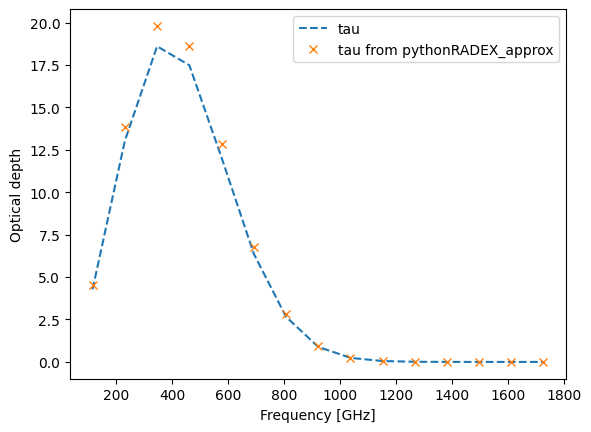

In [13]:
# plot the optical depth
plt.plot(nu0_arrayCo / constants.giga, tauCo, "--", label="tau")
plt.plot(nu0_arrayCo / constants.giga, tau_pythonRADEX_approx, "x", label="tau from pythonRADEX_approx")
# plt.plot(nu0_arrayCo / constants.giga, tau_manual_std, label="tau_manual_standard")


plt.xlabel("Frequency [GHz]")
plt.ylabel("Optical depth")
plt.legend()
plt.show()


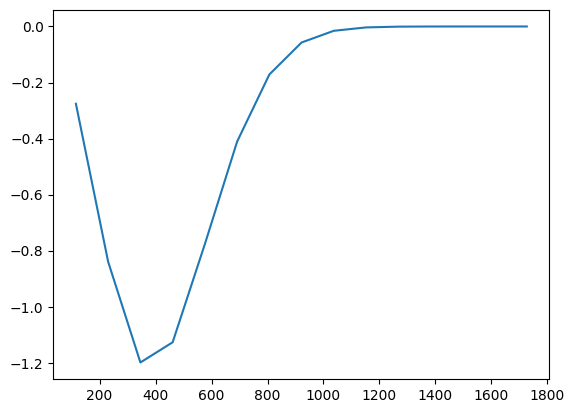

In [14]:
# plot the difference between the two methods
plt.plot(nu0_arrayCo / constants.giga, tauCo - tau_pythonRADEX_approx, label="tau - tau_manual")

# Population diagram fo CO, LTE case

In [15]:
# Calculate gamma * flux and compare with Nu
gamma_flux = gammaCo * fluxCo
print("gamma * flux (first 5):", gamma_flux[:5])
print("Nu (first 5):", NuCo[:5])
print("Are gamma * flux and Nu the same?", np.allclose(gamma_flux, NuCo))

gamma * flux (first 5): [7.60140386e-07 3.23141705e-06 6.60997852e-06 1.01297548e-05
 1.29117491e-05]
Nu (first 5): [2.23030007e+21 2.57065402e+21 2.06977854e+21 1.27278291e+21
 6.18777563e+20]
Are gamma * flux and Nu the same? False


In [16]:
NuCo

array([2.23030007e+21, 2.57065402e+21, 2.06977854e+21, 1.27278291e+21,
       6.18777563e+20, 2.41916833e+20, 7.67974715e+19, 1.99146220e+19,
       4.23549433e+18, 7.40961075e+17, 1.06841296e+17, 1.27185079e+16,
       1.25150887e+15, 1.01892984e+14, 6.86888447e+12])

In [17]:
gammaCo

array([3.58536382e+15, 1.49489951e+15, 9.30735688e+14, 6.74383090e+14,
       5.28613492e+14, 4.34861572e+14, 3.69570434e+14, 3.21678670e+14,
       2.85092085e+14, 2.56389959e+14, 2.33016990e+14, 2.13953076e+14,
       1.97961708e+14, 1.84345178e+14, 1.72753430e+14])

In [18]:
gammaCo * fluxCo

array([7.60140386e-07, 3.23141705e-06, 6.60997852e-06, 1.01297548e-05,
       1.29117491e-05, 1.38490604e-05, 1.14914754e-05, 6.30780208e-06,
       2.23324173e-06, 5.62259974e-07, 1.09096623e-07, 1.68890001e-08,
       2.11260617e-09, 2.14720828e-10, 1.77938372e-11])

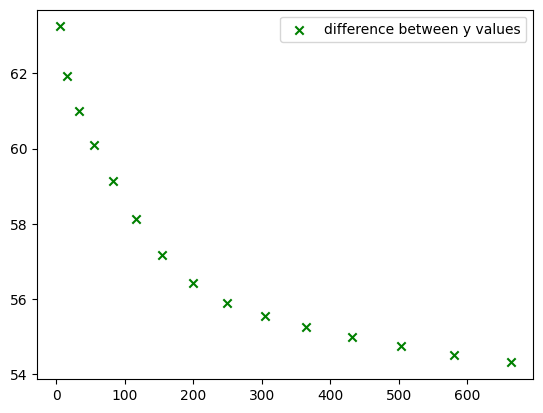

In [19]:
# calculate escape probability for each transition
beta = (1 - np.exp(-tauCo)) / tauCo
# Replace 0 with nan in beta
beta[beta == 0] = np.nan

# get the y axis of the plot: ln(γ_u * W / g_u)
y_values = np.log(gammaCo * fluxCo / gCO)

# calculate get y values using column density of the upper level
y_values_Nu = np.log(NuCo / gCO)
# calculate y values using column density of the upper level and beta
y_value_Nu_beta_consideration = np.log(NuCo / (beta * gCO))

diff_beta = y_values_Nu - y_values

# plot population diagram
fig, ax = plt.subplots()

# plot y values considering escape probaility
plt.scatter(EuCo, diff_beta, marker="x", color="green", label="difference between y values")
plt.legend()


In [20]:
y_values / y_values_Nu

array([-0.28663116, -0.28508816, -0.28514251, -0.28823288, -0.29455923,
       -0.30502993, -0.32248881, -0.35182833, -0.39556985, -0.45378805,
       -0.52745026, -0.61956892, -0.7352915 , -0.88253823, -1.07364201])

## Not working population diagram 

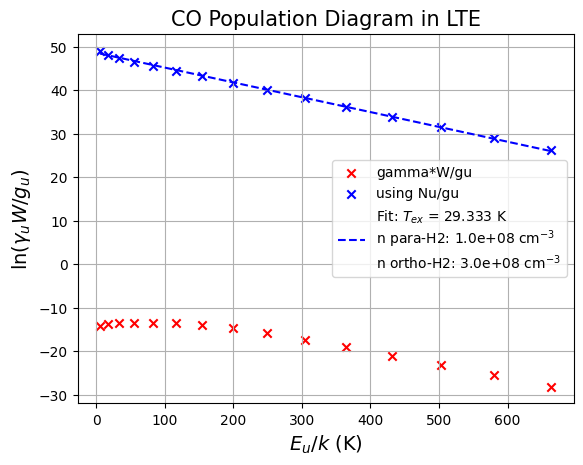

In [21]:
# plot population diagram
fig, ax = plt.subplots()
plt.scatter(EuCo, y_values, marker="x", color="red", label="gamma*W/gu")
plt.scatter(EuCo, y_values_Nu, marker="x", color="blue", label="using Nu/gu")

# plot y values considering escape probaility
# plt.scatter(EuCo, y_value_new_beta_consideration, marker="x", color="green", label="considering beta and Nu")


plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# # Fit a straight line to estimate T_ex
fit = np.polyfit(EuCo, y_values_Nu, 1)  # Linear fit
T_ex = -1 / fit[0]  # Rotational temperature from slope

# Plot the best-fit line
x_fit = np.linspace(min(EuCo), max(EuCo), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(
        f"Fit: $T_{{ex}}$ = {T_ex:.5g} K\nn para-H2: {para_h2_density:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density:.1e} cm$^{{-3}}$"
    ),
)
plt.legend()
ax.grid()
plt.show()

### why the the two y axis are different???

## Final population diagram

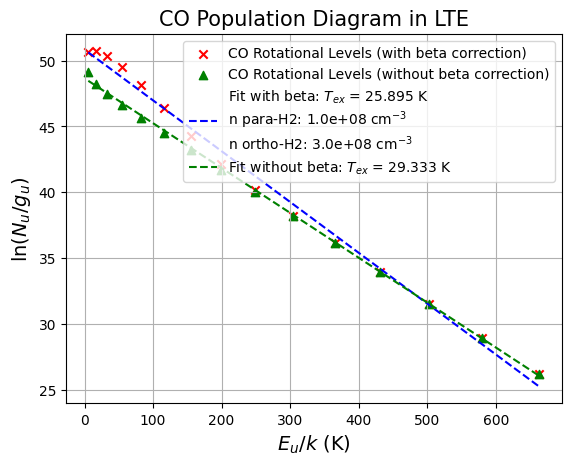

In [22]:
# calculate escape probability for each transition
beta_LTE = (1 - np.exp(-tauCo)) / tauCo

# create a mask for tau_co values greater than 0.1, returns a boolean array
mask_tau_LTE = tauCo > 0.0001

# initialize y_values_LTE with the values without beta correction
y_values_LTE = np.log(NuCo / gCO)

# apply beta correction only for values where tau_co > 0.1
y_values_LTE[mask_tau_LTE] = np.log(NuCo[mask_tau_LTE] / (gCO[mask_tau_LTE] * beta_LTE[mask_tau_LTE]))

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(
    EuCo,
    y_values_LTE,
    marker="x",
    color="red",
    label="CO Rotational Levels (with beta correction)",
)
plt.scatter(
    EuCo,
    np.log(NuCo / gCO),
    marker="^",
    color="green",
    label="CO Rotational Levels (without beta correction)",
)

plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/ g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# Fit a straight line to estimate T_ex with beta correction
fit_LTE = np.polyfit(EuCo, y_values_LTE, 1)  # Linear fit
T_ex_LTE = -1 / fit_LTE[0]  # Rotational temperature from slope

# Fit a straight line to estimate T_ex without beta correction
fit_no_beta = np.polyfit(EuCo, np.log(NuCo / gCO), 1)  # Linear fit
T_ex_no_beta = -1 / fit_no_beta[0]  # Rotational temperature from slope

# Plot the best-fit line with beta correction
x_fit_LTE = np.linspace(min(EuCo), max(EuCo), 100)
y_fit_LTE = fit_LTE[0] * x_fit_LTE + fit_LTE[1]
plt.plot(
    x_fit_LTE,
    y_fit_LTE,
    linestyle="--",
    color="blue",
    label=(
        f"Fit with beta: $T_{{ex}}$ = {T_ex_LTE:.5g} K\nn para-H2: {para_h2_density:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density:.1e} cm$^{{-3}}$"
    ),
)

# Plot the best-fit line without beta correction
y_fit_no_beta = fit_no_beta[0] * x_fit_LTE + fit_no_beta[1]
plt.plot(
    x_fit_LTE,
    y_fit_no_beta,
    linestyle="--",
    color="green",
    label=(f"Fit without beta: $T_{{ex}}$ = {T_ex_no_beta:.5g} K"),
)

plt.legend()
ax.grid()
plt.show()


### why the one without beta correction is getting a better T_ex????

In [23]:
print(f"Excitation temperature with escape probability correction: {T_ex_LTE:.5g} K")
print(f"Excitation temperature without escape probability correction: {T_ex_no_beta:.5g} K")
print(f"kinetic temperature of the nebula: {Tkin} K")  # kinetic temperature in K)

Excitation temperature with escape probability correction: 25.895 K
Excitation temperature without escape probability correction: 29.333 K
kinetic temperature of the nebula: 30 K


As expected in LTE:
$$T_{ex} = T_{kin}$$

However the y axis have the wrong sign

# Escape propability investigation
Escape probability for a homogeneous, static sphere is given by:

 
$$
\beta_{sphere}(\tau_\nu) = \frac{3}{2\tau_\nu} \left( 1 - \frac{2}{\tau_\nu^2} + \left( \frac{2}{\tau_\nu} + \frac{2}{\tau_\nu^2} \right) e^{-\tau_\nu} \right)
$$

$\tau_\nu$ is the optical depth.
Escape probability for expanding spherical shell, appriximation know as the large
velocity gradient (LVG) approximation:

$$ \beta_{slab}(\tau) = \frac{1 - e^{-\tau}}{\tau}$$



Escape probability of a homogeneous slab with a constant velocity gradient: 
$$\beta_{slab}(\tau) = \frac{1 - e^{-3\tau}}{3\tau}
 $$
Escape probability used by RADEX of a LVG sphere:
 $$\beta(\tau) = \frac{1}{\tau_\nu \sqrt{\ln(\tau_\nu / (2\sqrt{\pi}))}} \quad \text{if } \tau_\nu > 7
 $$

 $$\beta(\tau) = \frac{4 - 4e^{-2.34\tau_\nu / 2}}{4.68\tau_\nu} \quad \text{if } \tau_\nu < 7
$$

Equation for the population diagram taking into acount optical depth is: 
$$
ln{\frac{\gamma_u W}{g_u \beta}}=ln{N/Z}-\frac{E_u}{kT}
$$

C:\Users\alios\AppData\Local\Temp\ipykernel_18752\3645807962.py:33: RuntimeWarning: invalid value encountered in sqrt
  1 / (tau_nu * np.sqrt(np.log(tau_nu / (2 * np.sqrt(np.pi))))),
C:\Users\alios\AppData\Local\Temp\ipykernel_18752\3645807962.py:47: RuntimeWarning: invalid value encountered in sqrt
  1 / (tau_nu * np.sqrt(np.log(tau_nu / (np.sqrt(np.pi))))),


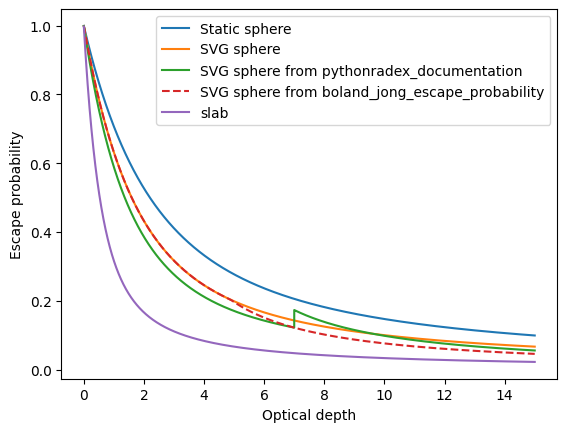

In [24]:
# different ways to calculate the escape probability
def beta_sphere(tau_nu):
    """Calculate the escape probability for homogeneous, static sphere"""
    tau_nu = np.where(tau_nu == 0, np.nan, tau_nu)  # Avoid division by zero
    return (3 / (2 * tau_nu)) * (1 - (2 / tau_nu**2) + ((2 / tau_nu) + (2 / tau_nu**2)) * np.exp(-tau_nu))


def svg_escape_probability(tau_nu):
    """Calculate the escape probability for an expanding sphere"""
    tau_nu = np.where(tau_nu == 0, np.nan, tau_nu)  # Avoid division by zero
    return (1 - np.exp(-tau_nu)) / tau_nu


def beta_slab(tau_nu):
    """Calculate the escape probability for a slab"""
    tau_nu = np.where(tau_nu == 0, np.nan, tau_nu)  # Avoid division by zero
    return (1 - np.exp(-3 * tau_nu)) / (3 * tau_nu)


def beta_pythonradex_documentation(tau_nu):
    """
    Calculate the escape probability based on RADEX documentation.

    Parameters:
    tau_nu (float or np.array): Optical depth τ_ν.

    Returns:
    float or np.array: Computed β(τ_ν).
    """
    tau_nu = np.where(tau_nu == 0, np.nan, tau_nu)  # Avoid division by zero
    beta = np.where(
        tau_nu >= 7,
        1 / (tau_nu * np.sqrt(np.log(tau_nu / (2 * np.sqrt(np.pi))))),
        (4 - 4 * np.exp(-2.34 * tau_nu / 2)) / (4.68 * tau_nu),
    )
    return beta


def boland_jong_escape_probability(tau_nu):
    """
    Compute escape probability based on equation given in appendix A.
    """
    tau_nu = np.where(tau_nu == 0, np.nan, tau_nu)  # Avoid division by zero
    beta = np.where(
        tau_nu < 4.9,
        (1 - np.exp(-tau_nu)) / tau_nu,
        1 / (tau_nu * np.sqrt(np.log(tau_nu / (np.sqrt(np.pi))))),
    )
    return beta


tau_array = np.linspace(0, 15, int(1e4))
beta_sphere_array = beta_sphere(tau_array)
svg_escape_probability_array = svg_escape_probability(tau_array)
beta_slab_array = beta_slab(tau_array)
tau_pythonradex_documentation_array = beta_pythonradex_documentation(tau_array)
boland_jong_escape_probability_array = boland_jong_escape_probability(tau_array)

# plot the escape probability
plt.plot(tau_array, beta_sphere_array, label="Static sphere")
plt.plot(tau_array, svg_escape_probability_array, label="SVG sphere")

plt.plot(tau_array, tau_pythonradex_documentation_array, label="SVG sphere from pythonradex_documentation")
plt.plot(tau_array, boland_jong_escape_probability_array, "--", label="SVG sphere from boland_jong_escape_probability")
plt.plot(tau_array, beta_slab_array, label="slab")


plt.xlabel("Optical depth")
plt.ylabel("Escape probability")
plt.legend()
plt.show()

In [25]:
# get optical depth
tauCo = cloud.tau_nu(nu=nu0_arrayCo)
tauCo

array([4.27823887e+00, 1.30241507e+01, 1.86005224e+01, 1.74816097e+01,
       1.20401125e+01, 6.37136221e+00, 2.65716018e+00, 8.86205447e-01,
       2.38671953e-01, 5.22293427e-02, 9.34442191e-03, 1.36923044e-03,
       1.64935772e-04, 1.63688216e-05, 1.33944263e-06])

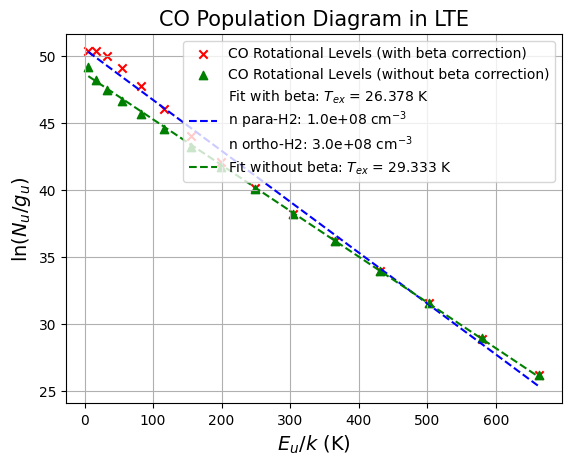

In [49]:
# calculate escape probability for each transition
beta_sphere_correction = beta_sphere(tauCo)

# create a mask for tau_co values greater than 0.1, returns a boolean array
mask_tau_LTE = tauCo > 0.00001

# initialize y_values_LTE with the values without beta correction
y_values_LTE = np.log(NuCo / gCO)

# apply beta correction only for values where tau_co > 0.1
y_values_LTE[mask_tau_LTE] = np.log(NuCo[mask_tau_LTE] / (gCO[mask_tau_LTE] * beta_sphere_correction[mask_tau_LTE]))

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(
    EuCo,
    y_values_LTE,
    marker="x",
    color="red",
    label="CO Rotational Levels (with beta correction)",
)
plt.scatter(
    EuCo,
    np.log(NuCo / gCO),
    marker="^",
    color="green",
    label="CO Rotational Levels (without beta correction)",
)

plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/ g_u)$", fontsize=14)
plt.title("CO Population Diagram in LTE", fontsize=15)

# Fit a straight line to estimate T_ex with beta correction
fit_LTE = np.polyfit(EuCo, y_values_LTE, 1)  # Linear fit
T_ex_LTE = -1 / fit_LTE[0]  # Rotational temperature from slope

# Fit a straight line to estimate T_ex without beta correction
fit_no_beta = np.polyfit(EuCo, np.log(NuCo / gCO), 1)  # Linear fit
T_ex_no_beta = -1 / fit_no_beta[0]  # Rotational temperature from slope

# Plot the best-fit line with beta correction
x_fit_LTE = np.linspace(min(EuCo), max(EuCo), 100)
y_fit_LTE = fit_LTE[0] * x_fit_LTE + fit_LTE[1]
plt.plot(
    x_fit_LTE,
    y_fit_LTE,
    linestyle="--",
    color="blue",
    label=(
        f"Fit with beta: $T_{{ex}}$ = {T_ex_LTE:.5g} K\nn para-H2: {para_h2_density:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density:.1e} cm$^{{-3}}$"
    ),
)

# Plot the best-fit line without beta correction
y_fit_no_beta = fit_no_beta[0] * x_fit_LTE + fit_no_beta[1]
plt.plot(
    x_fit_LTE,
    y_fit_no_beta,
    linestyle="--",
    color="green",
    label=(f"Fit without beta: $T_{{ex}}$ = {T_ex_no_beta:.5g} K"),
)

plt.legend()
ax.grid()
plt.show()


# Line profile of CO, LTE case
Spectrum function finds flux density in $W/m^2 Hz$, notice this is just $J/m^2$

fluxes_of_individual_transitions finds flux in $W/m^2$

## Gaussian and total gaussian functions

In [27]:
def gaussian(x, amp, cen, fwhm):
    """
    Gaussian function.

    Parameters:
        x: array-like, the independent variable (e.g., wavelength)
        amp: float, the amplitude of the Gaussian
        cen: float, the center of the Gaussian
        fwhm: float, the full width at half maximum of the Gaussian

    Returns:
        The Gaussian evaluated at x.
    """
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amp * np.exp(-((x - cen) ** 2) / (2 * sigma**2))


# Define the model: a sum of Gaussians.
def model_spectrum(x, params):
    """
    Create spectrum, sum of Gaussians.

    Parameters:
        x: array-like, the independent variable (e.g., frequency)
        params: list or array of parameters. For n Gaussians, params should be of length 3*n,
                where each Gaussian has [amp, cen, fwhm] in order.

    Returns:
        The sum of Gaussians evaluated at x.
    """
    n_gauss = len(params) // 3
    total = np.zeros_like(x)
    for i in range(n_gauss):
        amplitude = params[3 * i]
        center = params[3 * i + 1]
        fwhm = params[3 * i + 2]
        # print(f"Transition {i}: amplitude={amplitude}, center={center}, width={fwhm}")

        total += gaussian(x, amplitude, center, fwhm)
    return total


## Spectrum using flux  

### Frequency space

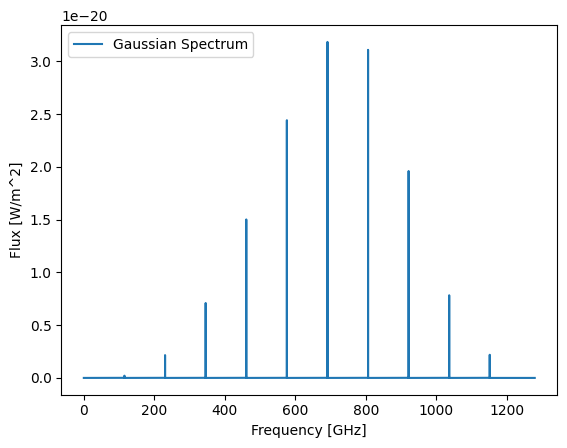

In [28]:
# number of transitions to plot in spectrum
n_trans_spectrum = 10

# generate frequancy space
x = np.linspace(0, nu0_arrayCo[n_trans_spectrum] * 1.01, int(1e7))
params = []
for i in range(n_trans_spectrum):
    params.extend([fluxCo[i], nu0_arrayCo[i], FWHMCO[i]])

# Generate the spectrum
spectrum = model_spectrum(x, params)

# Plot the spectrum
fig, ax = plt.subplots()
plt.plot(x / constants.giga, spectrum, label="Gaussian Spectrum")
plt.xlabel("Frequency [GHz]")
plt.ylabel(r"Flux [W/m^2]")
plt.legend()
plt.show()

#### Spectrum in frequency space using Stem plot 

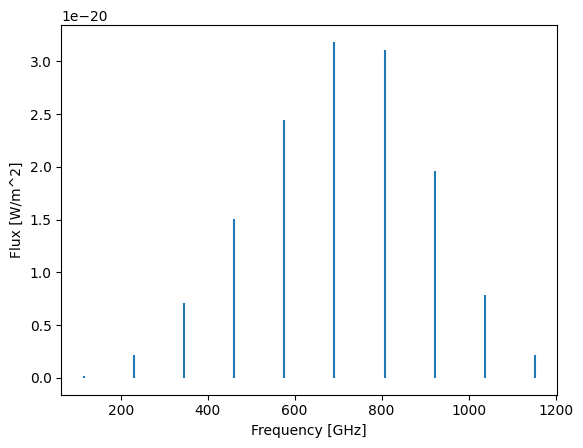

In [29]:
# plot the spectrum with individual fluxes
plt.stem(nu0_arrayCo[:n_trans_spectrum] / constants.giga, fluxCo[:n_trans_spectrum], basefmt=" ", markerfmt=" ")

# to plot as a gaussina curve
# plt.plot(array_nu0 / constants.giga, flux, drawstyle="steps-mid")

plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux [W/m^2]")
plt.show()

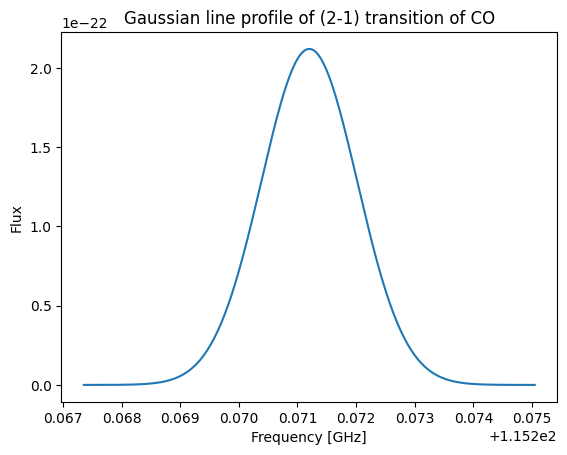

In [30]:
# FWHMCO of first transition
first_fwhm = FWHMCO[0]
x = np.linspace(nu0_arrayCo[0] - 2 * first_fwhm, nu0_arrayCo[0] + 2 * first_fwhm, int(1e7))
params = []
for i in range(NUM_TRANSITIONS):
    params.extend([fluxCo[i], nu0_arrayCo[i], FWHMCO[i]])


# Generate the spectrum
single_spectrum = model_spectrum(x, params)

# plot frequency vs flux
fig, ax = plt.subplots()
plt.title("Gaussian line profile of (2-1) transition of CO")
plt.plot(x / constants.giga, single_spectrum)
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.show()

### Spectrum with arbitrary large FWHM

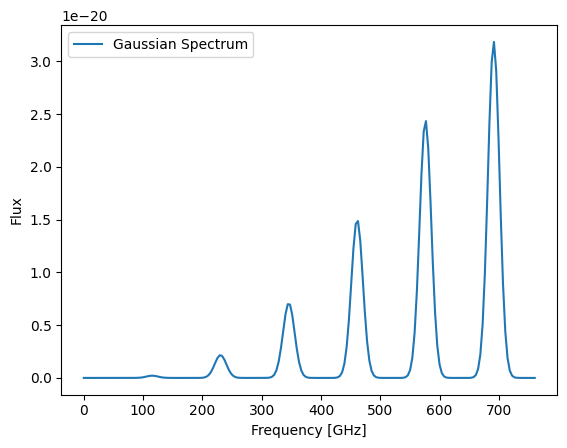

In [31]:
#  arbitrary fwhm
fwhm_frequancy = nu0_arrayCo[1] * 0.1

# Example usage
x = np.linspace(0, nu0_arrayCo[5] * 1.1, 200)
params = []
for i in range(NUM_TRANSITIONS):
    # fwhm_frequancy = nu0_arrayCo[i] * 0.1
    params.extend([fluxCo[i], nu0_arrayCo[i], fwhm_frequancy])

# Generate the spectrum
spectrum = model_spectrum(x, params)

# Plot the spectrum
fig, ax = plt.subplots()
plt.plot(x / constants.giga, spectrum, label="Gaussian Spectrum")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.show()

### Velocity space

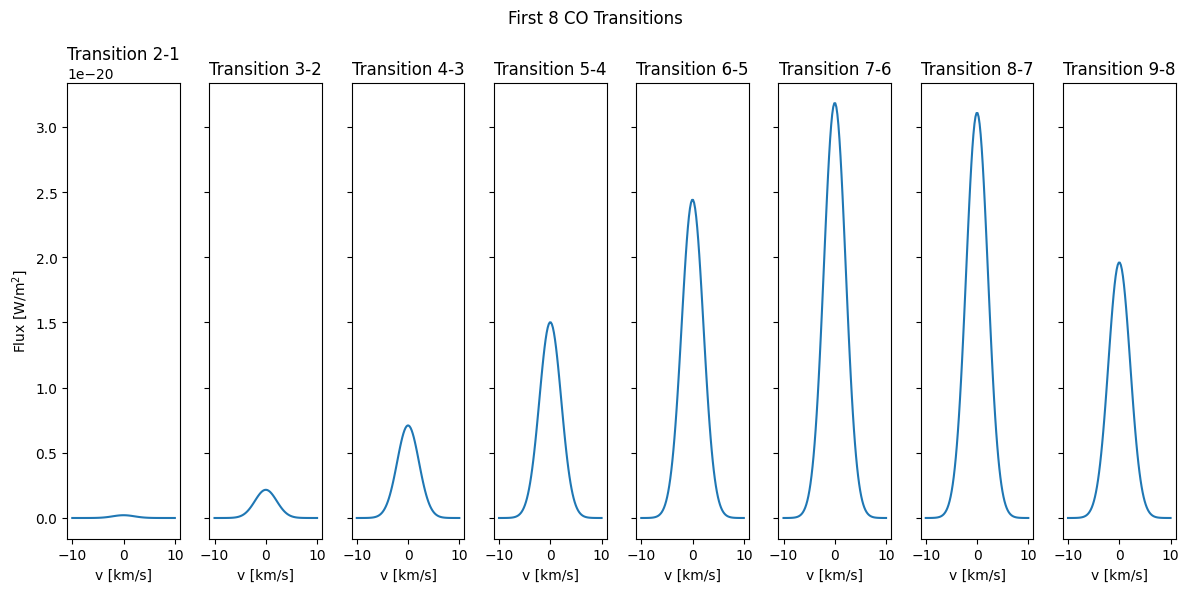

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = nu0_arrayCo[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity

    # Calculate Gaussian profile
    fwhm = nu0 * (width_v / constants.c)
    spectrum = gaussian(nu, fluxCo[i], nu0, fwhm)

    ax = axes[i]
    ax.plot(v / constants.kilo, spectrum)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"Flux [W/m$^2$]")

fig.tight_layout()
plt.show()

## Spectum in velocity space using flux density 

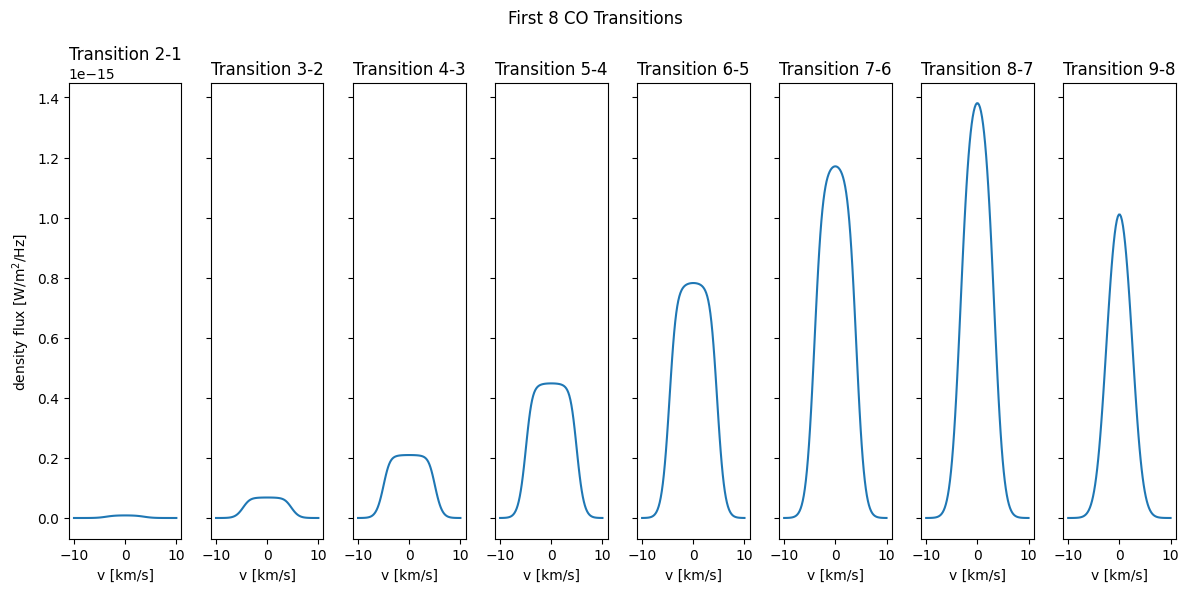

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = nu0_arrayCo[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity
    spectrum = cloud.spectrum(
        nu=nu, solid_angle=source_solid_angle
    )  # Compute spectrum, this give the flux density in W/m^2Hz

    ax = axes[i]
    ax.plot(v / constants.kilo, spectrum * nu)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"density flux [W/m$^2$/Hz]")

fig.tight_layout()
plt.show()

# CO for non-LTE case

## Update cloud

In [34]:
# update the claud using low densities of h2
# collider densities in cm-3:
para_h2_density_nonLTE = 1e3
ortho_h2_density_nonLTE = 3e3


collider_densities_nonLTE = {
    "para-H2": para_h2_density_nonLTE / constants.centi**3,
    "ortho-H2": ortho_h2_density_nonLTE / constants.centi**3,
}

cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_nonLTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

cloud.solve_radiative_transfer()

In [35]:
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202      28.25       0.104638       0.258089         5.2882
   2    1     230.538000      27.54       0.258089       0.287849        16.1649
   3    2     345.795990      26.29       0.287849       0.214339        22.9474
   4    3     461.040768      23.11       0.214339       0.105777        21.3805
   5    4     576.267931      17.67       0.105777      0.0270289        13.1415
   6    5     691.473076      12.33      0.0270289     0.00216687        3.87678
   7    6     806.651806      12.17     0.00216687    0.000103892       0.314696
   8    7     921.799700      16.53    0.000103892    8.10188e-06      0.0144759
   9    8    1036.912393      18.53    8.10188e-06    6.17184e-07     0.00111745
  10    9    1151.985452      19.66    6.17184e-07    4.10105e-08    8.49826e-05
  11   10    1267.014486      20.31    4.10105e-08    2.24832e-09    5.65792e-06
  12   11    1381.995105   

## Plot spectrum lines, non-LTE case

In [36]:
# initialize the class with the new cloud object
CO_cloud_instance_nonLTE = myclass(cloud, data_co, N, width_v, Tkin)
# get the values from the non-LtE cloud object and the data file

TexCo_nonLTE, tauCo_nonLTE, _, _, _, _, _, gammaCo_nonLTE, NuCo_nonLTE, NlCo_nonLTE, FWHMCO_nonLTE = (
    CO_cloud_instance_nonLTE.extract_and_calculate(debug=True)
)


# Slice all the arrays to get only the first NUM_TRANSITIONS transitions
TexCo_nonLTE = TexCo_nonLTE[:NUM_TRANSITIONS]
tauCo_nonLTE = tauCo_nonLTE[:NUM_TRANSITIONS]
gammaCo_nonLTE = gammaCo_nonLTE[:NUM_TRANSITIONS]
NuCo_nonLTE = NuCo_nonLTE[:NUM_TRANSITIONS]
NlCo_nonLTE = NlCo_nonLTE[:NUM_TRANSITIONS]


Size of levels: 41
Size of rad_transitions: 40
Size of nu0_array: 40
Are tau_nu0_individual_transitions function and tau_nu function the same? True


In [37]:
# calculate the observed fluxes [W/m2], outputed as a list
flux_nonLTE = cloud.fluxes_of_individual_transitions(transitions=None, solid_angle=source_solid_angle)

# convert flux to np.array
flux_nonLTE = np.array(flux_nonLTE)

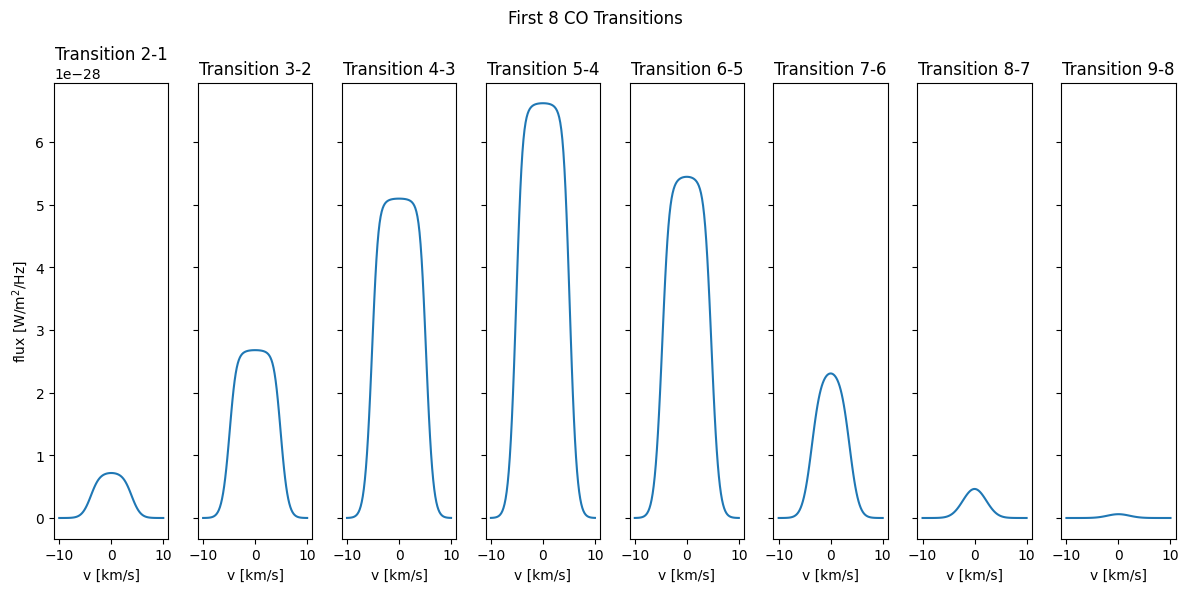

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 CO Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = nu0_arrayCo[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity
    spectrum = cloud.spectrum(nu=nu, solid_angle=source_solid_angle)  # Compute spectrum

    ax = axes[i]  # Select subplot in 2x4 grid
    ax.plot(v / constants.kilo, spectrum)
    ax.set_title(f"Transition {i + 2}-{i + 1}")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"flux [W/m$^2$/Hz]")

fig.tight_layout()
plt.show()

## Plot CO population diagram, non-LTE case

In [39]:
len(gCO)

15

In [40]:
len(tauCo_nonLTE)

15

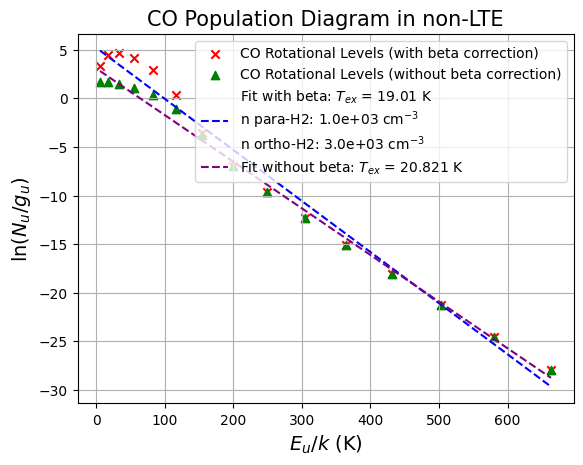

In [41]:
# calculate escape probability for each transition
beta_nonLTE = (1 - np.exp(-tauCo_nonLTE)) / tauCo_nonLTE

# create a mask for tau_co_nonLTE values greater than 0.1, returns a boolean array
mask_tau = tauCo_nonLTE > 0.1

# initialize y_values_nonLTE with the values without beta correction
y_values_nonLTE = np.log(tauCo_nonLTE / gCO)

# apply beta correction only for values where tau_co_nonLTE > 0.1
y_values_nonLTE[mask_tau] = np.log(tauCo_nonLTE[mask_tau] / (gCO[mask_tau] * beta_nonLTE[mask_tau]))

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(EuCo, y_values_nonLTE, marker="x", color="red", label="CO Rotational Levels (with beta correction)")
plt.scatter(
    EuCo, np.log(tauCo_nonLTE / gCO), marker="^", color="green", label="CO Rotational Levels (without beta correction)"
)
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/ g_u)$", fontsize=14)
plt.title("CO Population Diagram in non-LTE", fontsize=15)

# Fit a straight line to estimate T_ex with beta correction
fit = np.polyfit(EuCo, y_values_nonLTE, 1)  # Linear fit
T_ex_nonLTE = -1 / fit[0]  # Rotational temperature from slope

# Fit a straight line to estimate T_ex without beta correction
fit_no_beta = np.polyfit(EuCo, np.log(tauCo_nonLTE / gCO), 1)  # Linear fit
T_ex_nonLTE_no_beta = -1 / fit_no_beta[0]  # Rotational temperature from slope

# Plot the best-fit line with beta correction
x_fit = np.linspace(min(EuCo), max(EuCo), 100)
y_fit = fit[0] * x_fit + fit[1]
plt.plot(
    x_fit,
    y_fit,
    linestyle="--",
    color="blue",
    label=(
        f"Fit with beta: $T_{{ex}}$ = {T_ex_nonLTE:.5g} K\nn para-H2: {para_h2_density_nonLTE:.1e} cm$^{{-3}}$\nn ortho-H2: {ortho_h2_density_nonLTE:.1e} cm$^{{-3}}$"
    ),
)

# Plot the best-fit line without beta correction
y_fit_no_beta = fit_no_beta[0] * x_fit + fit_no_beta[1]
plt.plot(
    x_fit,
    y_fit_no_beta,
    linestyle="--",
    color="purple",
    label=(f"Fit without beta: $T_{{ex}}$ = {T_ex_nonLTE_no_beta:.5g} K"),
)

plt.legend()
ax.grid()
plt.show()

In [42]:
print(f"Excitation temperature: {T_ex_nonLTE:.5g} K")
print(f"Excitation temperature without beta correction: {T_ex_nonLTE_no_beta:.5g} K")
print(f"Kinetic temperature of the cloud: {Tkin} K")  # kinetic temperature in K)

Excitation temperature: 19.01 K
Excitation temperature without beta correction: 20.821 K
Kinetic temperature of the cloud: 30 K


# plot population diagram using equation for non-LTE

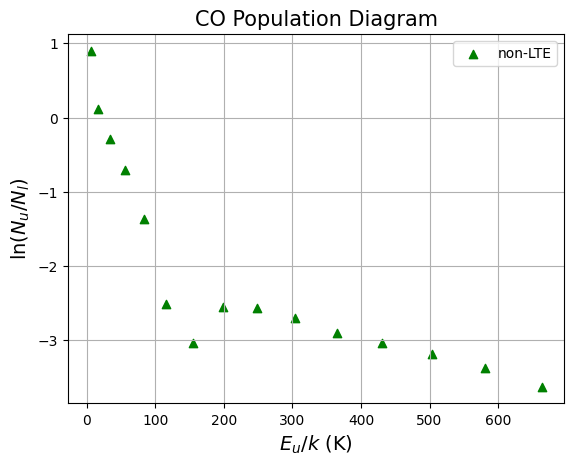

In [43]:
# plot log(Nu/Nl) vs Eu/k
fig, ax = plt.subplots()
# plt.scatter(EuCo, np.log(NuCo / NlCo), marker="x", color="red", label="LTE")
plt.scatter(EuCo, np.log(NuCo_nonLTE / NlCo_nonLTE), marker="^", color="green", label="non-LTE")
plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(N_u/N_l)$", fontsize=14)
plt.title("CO Population Diagram", fontsize=15)
plt.legend()
ax.grid()
plt.show()

# Plot population diagram for CH3OH-e

In [44]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CH3OH from LAMBDA database
datafilepath_methanol = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\e_ch3oh.dat"  # file downloaded from LAMDA database

# store the data
data_methanol = LAMDA_file.read(datafilepath_methanol, read_frequencies=False)

# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
Ntot_emeth = 1e16 / constants.centi**3  # total column density in m^-2
line_profile_type = "Gaussian"  # line profile, can be "rectangular" or "Gaussian"
width_v = 2 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud_metahnol = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

N = 1e16 / constants.centi**2  # CH3OH_e column density in m-2

# collider densities in m-3, for ch3oh-e ther is only one input parameter, hence no distinction between para- an otho-H2
LTE_collider_densities_h2only = {"H2": 1e8 / constants.centi**3}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud_metahnol.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=LTE_collider_densities_h2only,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer, i.e. calculate the level population with an iterative method
cloud_metahnol.solve_radiative_transfer()

79-78: tau_nu0 = -0.0189
46-45: tau_nu0 = -0.0535
28-27: tau_nu0 = -8.75e-06
91-89: tau_nu0 = -1.7e-05
13-12: tau_nu0 = -0.165
18-17: tau_nu0 = -0.18
10-8: tau_nu0 = -0.0918
23-22: tau_nu0 = -0.174
30-27: tau_nu0 = -0.159
37-36: tau_nu0 = -0.136
44-43: tau_nu0 = -0.101
54-53: tau_nu0 = -0.0681
65-64: tau_nu0 = -0.0403
49-48: tau_nu0 = -1.3e-12
79-77: tau_nu0 = -0.0217
92-91: tau_nu0 = -0.0106
105-104: tau_nu0 = -0.00443
121-120: tau_nu0 = -0.00183
68-66: tau_nu0 = -7.47e-06
9-7: tau_nu0 = -0.124
86-85: tau_nu0 = -0.000609
92-89: tau_nu0 = -0.00745
59-56: tau_nu0 = -0.0125
104-103: tau_nu0 = -5.39e-06
58-55: tau_nu0 = -2.16e-12
80-78: tau_nu0 = -3e-06
105-103: tau_nu0 = -0.00251
120-117: tau_nu0 = -1.09e-06
66-63: tau_nu0 = -1.93e-12
121-117: tau_nu0 = -0.000745
135-132: tau_nu0 = -9.72e-08


c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'
c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


In [45]:
cloud_metahnol.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
  79   78       2.937966      -0.43    0.000583222    0.000884515     -0.0189449
  14   13       3.387655       2.24      0.0285947      0.0341875    5.31779e-06
  96   95       7.284957       2.38    0.000115507    0.000109211     0.00105258
  30   28       9.413483      17.09      0.0197465      0.0166671    2.98087e-05
  46   45       9.923130      -4.93     0.00548232     0.00674886     -0.0534514
   5    4      12.171574       6.34      0.0502438      0.0327285        0.73659
 132  131      14.899685       2.24    1.87609e-05    1.27468e-05    6.23153e-06
  28   27      15.619187     -12.16      0.0160904      0.0197465   -8.75294e-06
  58   56      18.347298       5.25     0.00298288     0.00225659    9.73645e-06
   8    7      19.966178      32.46      0.0362893      0.0251669      0.0817325
  42   40      22.304559       4.24     0.00583529     0.00383486    4.73766e-13
  78   77      23.383812   

In [46]:
# # extract_values from the cloud object and the data file
# TexCH3OH, tauCH3OH, AulCH3OH, BulCH3OH, nu0_arrayCH3OH, EuCH3OH, gCH3OH, gammaCH3OH, tau_manualCH3OH, NuCH3OH = (
#     extract_and_calculate(cloud_metahnol, data_methanol, N, width_v, Tkin)
# )

# # Take only N first transitions
# firstN_transitions = 10
# TexCH3OH = TexCH3OH[:firstN_transitions]
# tauCH3OH = tauCH3OH[:firstN_transitions]
# AulCH3OH = AulCH3OH[:firstN_transitions]
# BulCH3OH = BulCH3OH[:firstN_transitions]
# nu0_arrayCH3OH = nu0_arrayCH3OH[:firstN_transitions]
# EuCH3OH = EuCH3OH[:firstN_transitions]
# gCH3OH = gCH3OH[:firstN_transitions]


# # compute the flux from the cloud
# distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
# source_radius = 10 * constants.au  # radius of the source in m
# # solid angle of the source
# source_solid_angle = source_radius**2 * np.pi / distance_observer**2


# flux_methanol = cloud_metahnol.fluxes_of_individual_transitions(
#     transitions=list(range(10)), solid_angle=source_solid_angle
# )

In [47]:
# # arbitarry fwhm
# fwhm_frequancy = nu0_arrayCo[0] * 0.1

# choose_transition = 5

# # Example usage
# x = np.linspace(0, nu0_arrayCH3OH[choose_transition] + 2 * fwhm_frequancy, 200)
# gaus_frequancy = gaussian(x, flux_methanol[choose_transition], nu0_arrayCH3OH[choose_transition], fwhm_frequancy)

# # plot frequency vs flux
# fig, ax = plt.subplots()
# plt.plot(x / constants.giga, gaus_frequancy, label="Spectum 5th transition")
# plt.xlabel("Frequency [GHz]")
# plt.ylabel("Flux")
# plt.legend()
# plt.show()

In [48]:
# # compute flux for the first 10 transitions

# # compute the flux from the cloud
# distance_observer = 100 * constants.parsec  # distance between the observer and the cloud in m
# source_radius = 10 * constants.au  # radius of the source in m
# # solid angle of the source
# source_solid_angle = source_radius**2 * np.pi / distance_observer**2

# frequancy_test = np.arange(1, 20, 0.005) * constants.giga

# # spectrum_methanol = cloud_metahnol.spectrum(solid_angle=source_solid_angle, nu=nu0_arrayCH3OH[:10])

# spectrum_methanol = cloud_metahnol.spectrum(solid_angle=source_solid_angle, nu=frequancy_test)